# **Small Project - Modeling the solution of PDEs using markov chains and the Monte Carlo method**
*Baptiste Arnaudo*

The objective of this project is to numerically solve different PDEs using the Monte Carlo method. \
We consider the domain $\mathbb{D} = [0, 1]^{2} \subset \mathbb{R}^{2}$
and $\varphi$ a regular function defined on the boundary of the domain $\mathbb{D}$.

# **Part 1 : The Laplace Equation**

We consider the Laplace equation:    
$$ \forall x, y \in \mathbb{D},\; \partial^{2}_{x}f(x,y) + \partial^{2}_{y}f(x,y) = 0 $$
with the boundary condition:    
$$ \forall x \in ∂\mathbb{D},\; f(x) = \varphi(x)$$

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [9]:
class Mesh() : # This class defines a discrete mesh of points in the plane
    def __init__(self, step: int) :
      self.step = step

    def create_mesh(self) :
      return np.array([[i/self.step, j/self.step] for j in range(1, self.step) for i in range(1, self.step)])

In [10]:
class RandomWalk() : # Class of the markov chain on the mesh. When the state is a point x, the probability to go to a neighbor y is 1/4
    def __init__(self, value, step: int) :
      self.value = value
      self.step = step

    def get_neighbors(self) :
      return [[self.value[0] + 1/self.step, self.value[1] + 1/self.step],
              [self.value[0] - 1/self.step, self.value[1] + 1/self.step],
              [self.value[0] + 1/self.step, self.value[1] - 1/self.step],
              [self.value[0] - 1/self.step, self.value[1] - 1/self.step]]

    def update(self) :
      self.value = self.get_random_neighbor()

    def get_random_neighbor(self) :
      liste_voisins = self.get_neighbors()
      return liste_voisins[random.randint(0, 3)]

    def is_out(self) :
      return self.value[0] < 1/self.step or self.value[0] > 1 - 1/self.step or self.value[1] < 1/self.step or self.value[1] > 1 - 1/self.step

In [11]:
def solution_app(start, step: int, K: int, phi) : # Approximates the solution via Monte-Carlo method
  acc = 0
  for _ in range(K) :
    rw = RandomWalk(start, step)
    while not rw.is_out() :
      rw.update()
    acc += phi(rw.value, step)
  return acc/K

Let's now vary the mesh's step to study the accuracy of the solutions.

In [12]:
steps = [30, 50, 70]
K = 70

In [13]:
def phi(point, step) : # Example function for the boundary condition
  if point[1] < 1/step or point[1] > 1 - 1/step :
    return 0
  if point[0] < 1/step or point[0] > 1 - 1/step :
    return 1
  return None

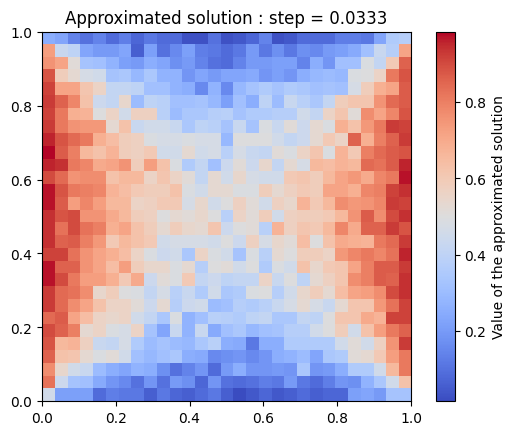

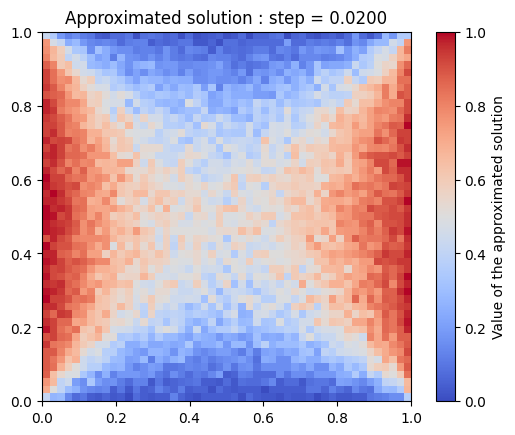

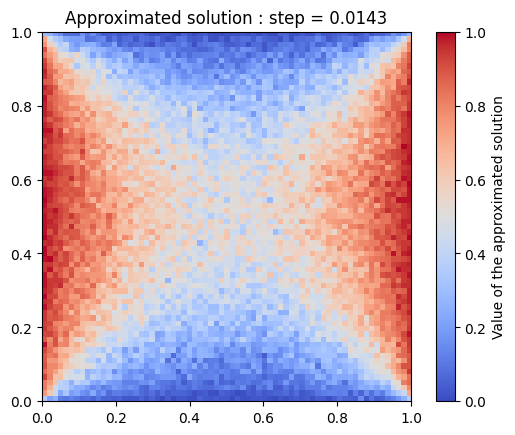

In [14]:
for p in steps : # We plot the approximated solution for different values of the step
  mesh = Mesh(p)
  l_points = np.array(mesh.create_mesh())
  val = np.array([solution_app(point, p, K, phi) for point in l_points])
  val_2d = val.reshape((p-1,p-1))
  plt.imshow(val_2d, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', interpolation='nearest')
  plt.title(f"Approximated solution : step = {1/p:.4f}")
  plt.colorbar(label="Value of the approximated solution")
  plt.show()

We can also test the influence of $K$, the number of iterations of the Monte-Carlo method

In [15]:
K = [10, 50, 100]
step = 50

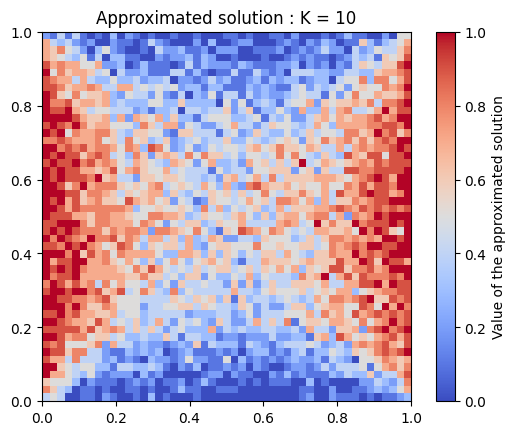

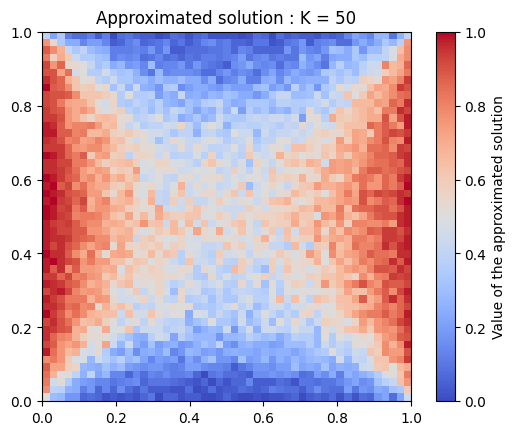

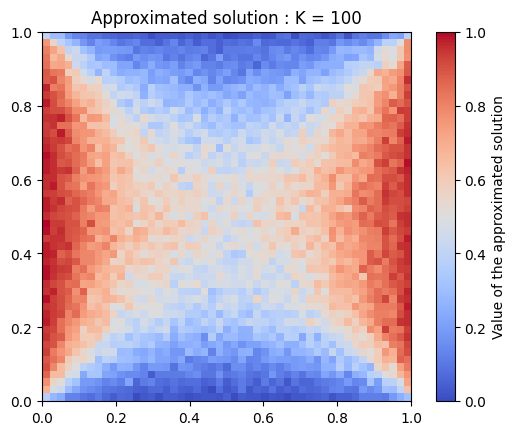

In [16]:
for k in K :
  mesh = Mesh(step)
  l_points = np.array(mesh.create_mesh())
  val = np.array([solution_app(point, step, k, phi) for point in l_points])
  val_2d = val.reshape((step-1,step-1))
  plt.imshow(val_2d, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', interpolation='nearest')
  plt.title(f"Approximated solution : K = {k}")
  plt.colorbar(label="Value of the approximated solution")
  plt.show()

The higher the value of $K$, the more defined the contour lines become as the traces of randomness disappear (a consequence of the almost sure convergence of the law of large numbers).

# **Part 2 : A more complex equation**

We assume $\varphi$ is positive. We fix $\gamma > 0$ and seek to calculate an approximate solution of the equation:    
$$ \forall x, y \in \mathbb{D},\;  \partial^{2}_{x}f(x,y) + \partial^{2}_{y}f(x,y) - \gamma f(x,y)= 0 $$
with the boundary condition:    
$$ \forall x \in ∂\mathbb{D},\; f(x) = \varphi(x)$$

Let $0 < \alpha < 1 $ such that $\frac{4\alpha}{1 - \alpha} = \gamma$ (i.e., $\alpha = \frac{\gamma}{4 + \gamma}$). We define a Markov chain on $\{\frac{i}{L}, 0 \leq i \leq L\}^{2} \cup \{m\}$ (where $m$ is an "absorbing" state) by its transition matrix $P$:    
$$ \forall x \in D_{L} := \{\frac{i}{L}, 0 \leq i \leq L \}^{2},\; P(x, m) = \alpha$$
$$ \forall x \in \partial D_{L},\; P(x,x) = 1; \quad \forall x \in D_{L},\; \forall y \sim x,\; P(x, y) = \frac{1 - \alpha}{4}$$
$$P(m, m) = 1$$
where $y \sim x$ means $y$ is a neighbor of $x$.
We also define $T = \inf \{n \geq 0,\; X_{n} \in \partial D_{L} \cup \{m\}\}$ and $F : x \mapsto \mathbb{E}_{x}[\varphi(X_{T})]$ (we define $\varphi(m) = 0$).

Using the expression of the discretized Laplacian ($\Delta F(x) = \sum_{y \sim x} (F(y) - F(x))$), let's show that $F$ satisfies the discretized version of the problem.

Let $x \in D_{L}$. We perform a first-step analysis. We have:
$$ F(x) = \sum_{y \sim x} \mathbb{E}_{x}(\varphi(X_{T})1_{X_{1} = y}) + \mathbb{E}_{x}(\varphi(X_{T})1_{X_{1} = m})$$
$$ = \sum_{y \sim x} \mathbb{E}_{x}(\varphi(X_{T})|X_{1}=y)\frac{1 - \alpha}{4} + \mathbb{E}_{x}(\varphi(X_{T})|X_{1} = m)\alpha $$
By time shift and considering that $\varphi(m) := 0$, we get:
$$F(x) = \frac{1 - \alpha}{4}\sum_{y \sim x} F(y) + \alpha \varphi(m) = \frac{1 - \alpha}{4}\sum_{y \sim x} F(y)$$
thus:
$$
F(x) = \frac{1 - \alpha}{4} ΔF(x) + (1 - \alpha)F(x)  
$$
or:
$$
ΔF(x) - \frac{4 \alpha}{1-\alpha}F(x) = ΔF(x) - \gamma F(x) = 0
$$


In [17]:
class RandomWalk1(RandomWalk) :
    def __init__(self, value, step: int, gamma: float) :
      super().__init__(value, step)
      self.gamma = gamma
      self.alpha = gamma/(4 + gamma)

    def update(self) :
      futurs_etats = self.get_neighbors() + ["m"]
      probabilities = [(1-self.alpha)/4]*4 + [self.alpha]
      self.value = random.choices(futurs_etats, probabilities, k=1)[0]

    def is_out(self) :
      return isinstance(self.value, str) or self.value[0] < 1/self.step or self.value[0] > 1 - 1/self.step or self.value[1] < 1/self.step or self.value[1] > 1 - 1/self.step

In [18]:
def phi(point, pas) : # Example function for the boundary condition
  if isinstance(point, str) or point[1] < 1/pas or point[1] > 1 - 1/pas :
    return 0
  if point[0] < 1/pas or point[0] > 1 - 1/pas :
    return 1
  return None

In [19]:
def solution_app(start, step: int, K: int, phi, gamma) :
  acc = 0
  for _ in range(K) :
    rw = RandomWalk1(start, step, gamma)
    while not rw.is_out() :
      rw.update()
    acc += phi(rw.value, step)
  return acc/K

Let's test the influence of $L$ (the inverse of the mesh's step) on the appearance of the solutions:

In [20]:
steps = [30, 50, 70]
K = 70
gamma = 0.1

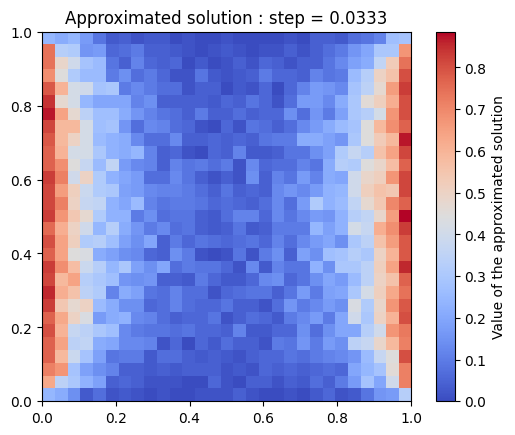

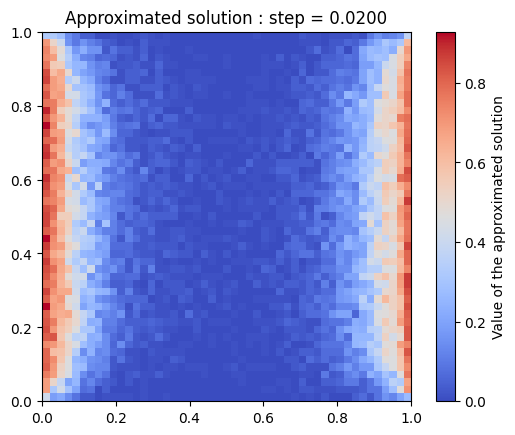

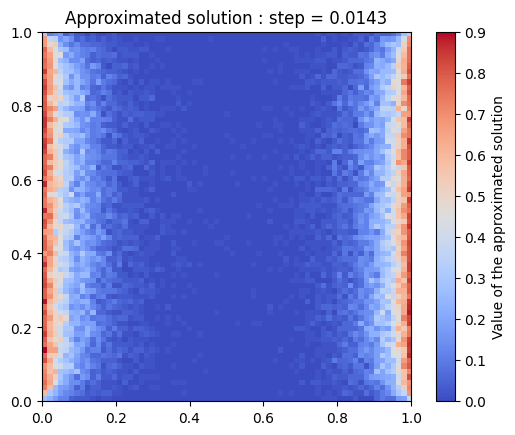

In [21]:
for p in steps :
  mesh = Mesh(p)
  l_points = np.array(mesh.create_mesh())
  val = np.array([solution_app(point, p, K, phi, gamma) for point in l_points])
  val_2d = val.reshape((p-1,p-1))
  plt.imshow(val_2d, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', interpolation='nearest')
  plt.title(f"Approximated solution : step = {1/p:.4f}")
  plt.colorbar(label="Value of the approximated solution")
  plt.show()

Let's test the influence of $\gamma$ on the appearance of the solutions:

In [22]:
gamma = [10**k for k in range(-3,1)]
step = 50

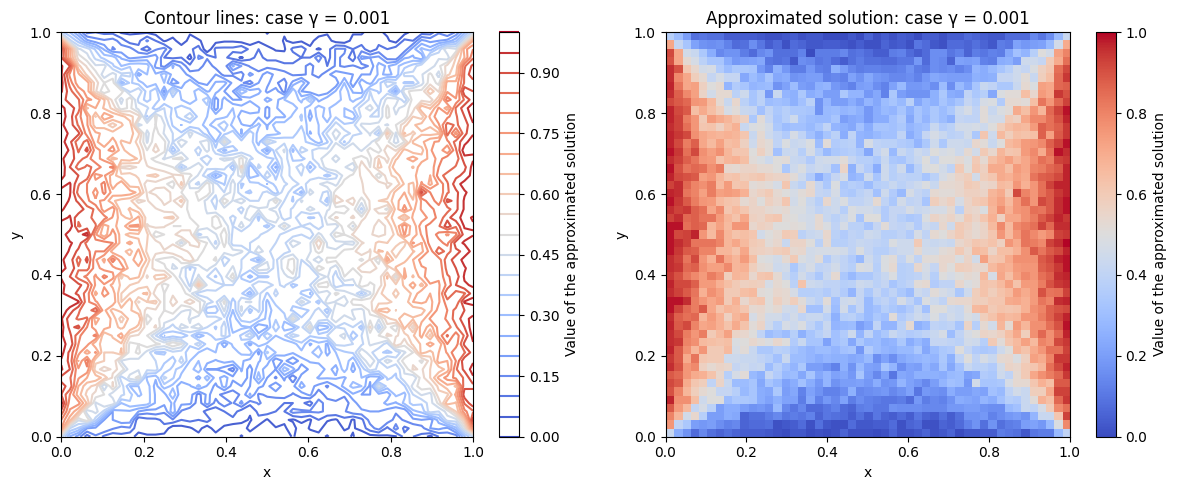

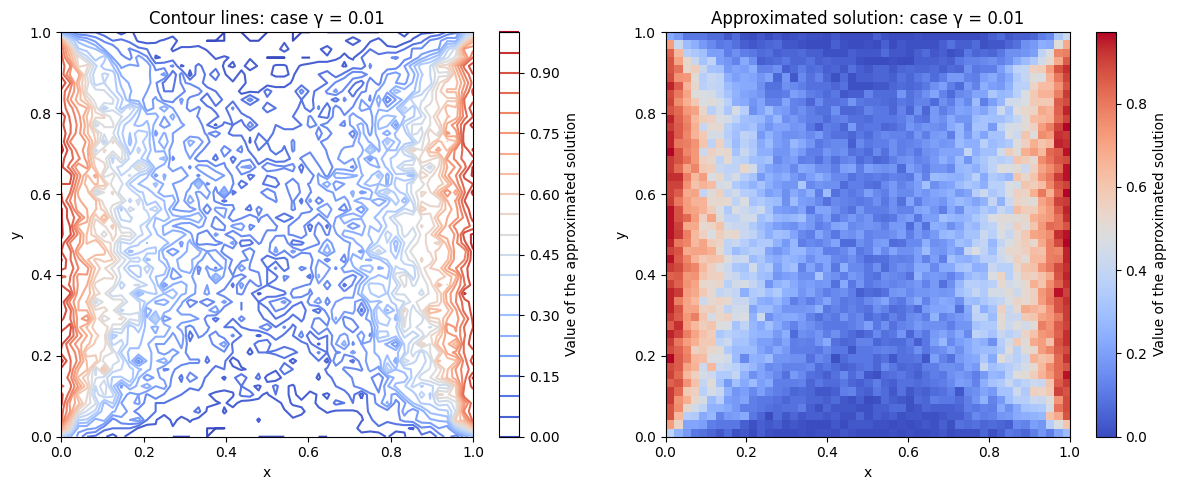

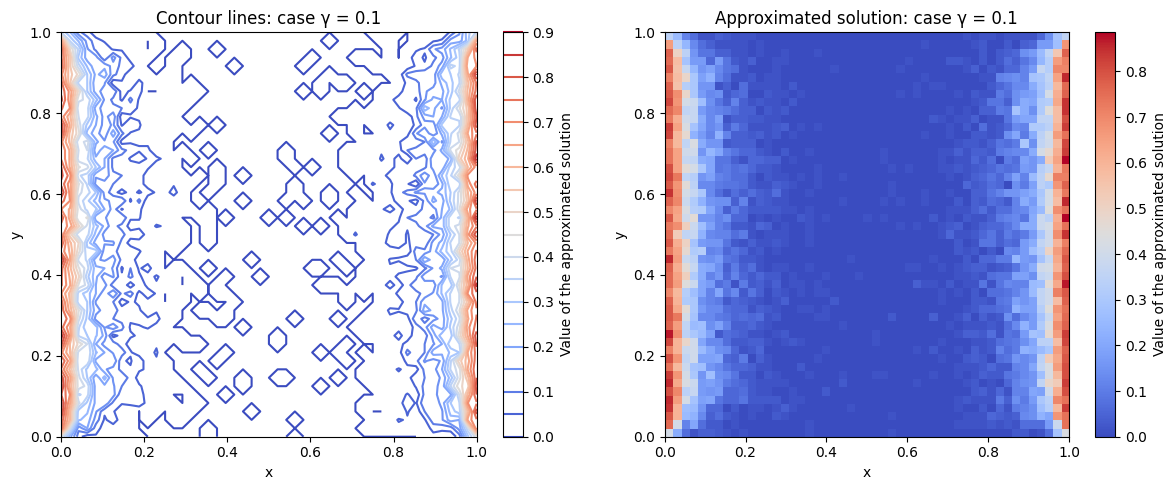

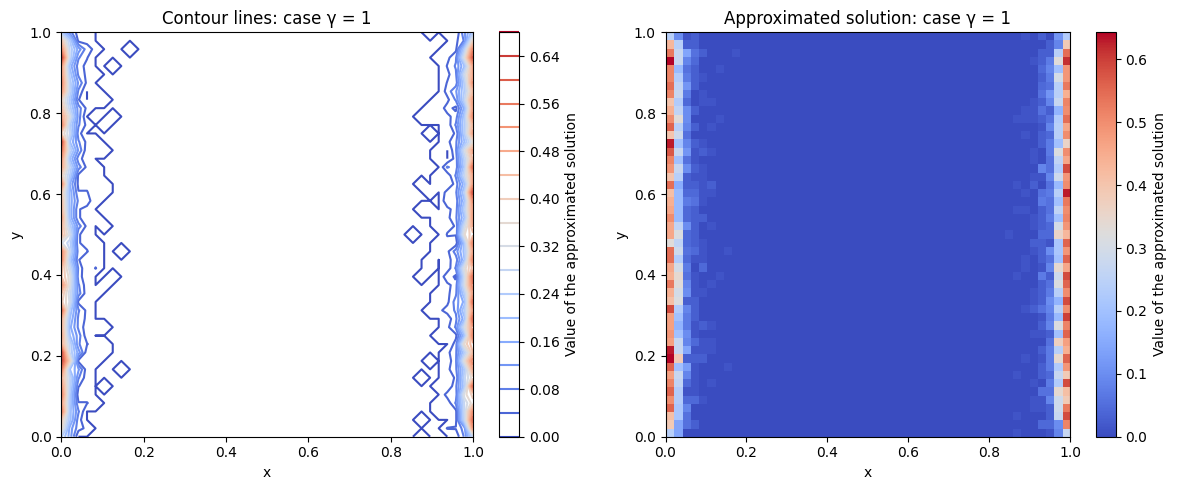

In [23]:
for g in gamma :
    mesh = Mesh(step)
    l_points = np.array(mesh.create_mesh())
    val = np.array([solution_app(point, p, K, phi, g) for point in l_points])
    val_2d = val.reshape((step - 1, step - 1))


    x = np.linspace(0, 1, step - 1)
    y = np.linspace(0, 1, step - 1)
    X, Y = np.meshgrid(x, y)


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Sub-plot 1: Contour lines
    contour = axs[0].contour(X, Y, val_2d, levels=20, cmap="coolwarm")
    axs[0].set_title(f"Contour lines: case γ = {g}")
    fig.colorbar(contour, ax=axs[0], label="Value of the approximated solution")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Sub-plot 2: Approximated solution
    im = axs[1].imshow(val_2d, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', interpolation='nearest')
    axs[1].set_title(f"Approximated solution: case γ = {g}")
    fig.colorbar(im, ax=axs[1], label="Value of the approximated solution")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()